#**Analisis Granular Kesehatan Mental Menggunakan IBM Granite untuk Strategi Intervensi Tertarget**

#**Import Library**

In [21]:
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.7 MB/s eta 0:00:00


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import getpass
import replicate
from tqdm.auto import tqdm

In [5]:
# Memuat dataset dari file CSV
file_path = 'Mental_health.csv'
df = pd.read_csv(file_path, engine='python', on_bad_lines='skip')

#**Eksplorasi Data**

In [8]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19641 entries, 0 to 19640
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  19641 non-null  int64 
 1   statement   19631 non-null  object
 2   status      19641 non-null  object
dtypes: int64(1), object(2)
memory usage: 460.5+ KB


In [10]:
# Mengatur gaya visualisasi
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

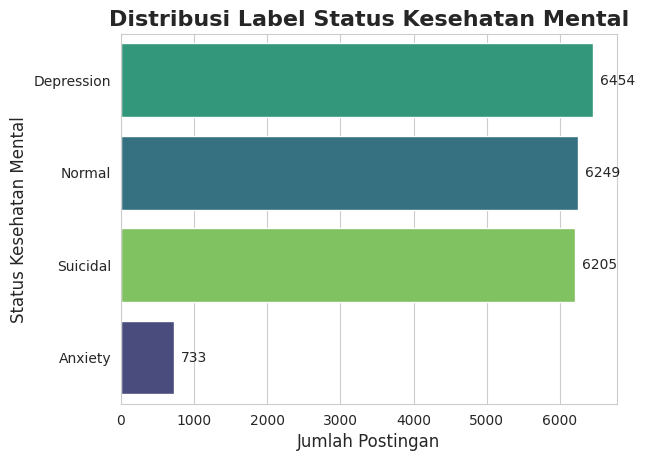

In [15]:
# Bar chart untuk menghitung distribusi 'Status'
ax = sns.countplot(y=df['status'],
                     order=df['status'].value_counts().index,
                   hue=df['status'],
                     palette='viridis')

# Menambahkan judul dan label
plt.title('Distribusi Label Status Kesehatan Mental', fontsize=16, fontweight='bold')
plt.xlabel('Jumlah Postingan', fontsize=12)
plt.ylabel('Status Kesehatan Mental', fontsize=12)

# Menambahkan anotasi jumlah pada setiap bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',
                (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(5, 0),
                textcoords='offset points', fontsize=10)

# Menampilkan plot
plt.show()

#**Pra-Pemrosesan Data & Definisi Kategori Pemicu**

In [18]:
def clean_text(text):
    """
    Fungsi untuk membersihkan teks dari:
    - URL
    - Mention (@username)
    - Hashtag (#topic)
    - Karakter non-alfanumerik (kecuali spasi)
    - Spasi berlebih
    """
    # Ensure the input is a string
    if not isinstance(text, str):
        return "" # Return empty string for non-string inputs

    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Hapus URL
    text = re.sub(r'\@\w+', '', text) # Hapus mention
    text = re.sub(r'#\w+', '', text) # Hapus hashtag
    text = re.sub(r'[^A-Za-z\s]+', '', text) # Hapus karakter non-alfanumerik
    text = re.sub(r'\s+', ' ', text).strip() # Hapus spasi berlebih
    return text.lower() # Ubah ke huruf kecil

# Menerapkan fungsi pembersihan pada kolom 'Statement'
df['cleaned_statement'] = df['statement'].apply(clean_text)

# Menampilkan perbandingan sebelum dan sesudah pembersihan
print("Contoh Perbandingan Teks Sebelum dan Sesudah Pembersihan:")
display(df[['statement', 'cleaned_statement']].head())

Contoh Perbandingan Teks Sebelum dan Sesudah Pembersihan:


,statement,cleaned_statement
0,oh my gosh,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",im restless and restless its been a month now ...


In [19]:
# Mendefinisikan daftar kategori pemicu untuk analisis Zero-Shot
trigger_categories = [
    "Masalah Hubungan",
    "Stres Akademik atau Pekerjaan",
    "Masalah Finansial",
    "Kesepian dan Isolasi Sosial",
    "Masalah Citra Tubuh dan Kepercayaan Diri",
    "Trauma dan Pengalaman Negatif Masa Lalu",
    "Kekhawatiran akan Masa Depan",
    "Kehilangan dan Duka"
]

print("Kategori Pemicu yang Akan Dianalisis:")
for category in trigger_categories:
    print(f"- {category}")

Kategori Pemicu yang Akan Dianalisis:
- Masalah Hubungan
- Stres Akademik atau Pekerjaan
- Masalah Finansial
- Kesepian dan Isolasi Sosial
- Masalah Citra Tubuh dan Kepercayaan Diri
- Trauma dan Pengalaman Negatif Masa Lalu
- Kekhawatiran akan Masa Depan
- Kehilangan dan Duka


#**Konfigurasi Model**

## Instalasi dan Konfigurasi API

In [23]:
try:
  from google.colab import userdata
  REPLICATE_API_TOKEN = userdata.get('REPLICATE_API_TOKEN')
  print("API Token berhasil dimuat")
except ImportError:
  print("Masukkan Replicate API Token")
  REPLICATE_API_TOKEN =getpass.getpass()

os.environ['REPLICATE_API_TOKEN'] = REPLICATE_API_TOKEN
print("Replicate API Token berhasil dikonfigurasi")

API Token berhasil dimuat
Replicate API Token berhasil dikonfigurasi


## Klasifikasi Zero Shot

In [26]:
def classify_statement_trigger(statement, categories):
  """
  Mengklasifikasikan sebuah pernyataan ke dalam kategori pemicu yang telah d
  ditentukan menggunakan model IBM Granite melalui Replicate API

  Args:
    statement (str): Teks pernyataan yang sudah dibersihkan
    categories (list): Daftar string kategori pemicu

  Returns:
    str: Kategori pemicu yang diprediksi oleh model.
  """
  # Menggabungkan daftar kategori menjadi sebuah string untuk prompt
  category_list_str = ", ".join(f'"{cat}"' for cat in categories)

  # Merancang prompt yang spesifik untuk tugas Zero-Shot Classification
  prompt = f"""
  Anda adalah seorang analisis ahli kesehatan mental. Tugas anda adalah
  mengidentifikasi pemicu utama (main trigger) pernyataan berikut
  PILIH HANYA SATU kategori yang paling relevan dari daftar di bawah ini.

  Pernyataan: "{statement}"

  Daftar Kategori: {category_list_str}

  Jawaban Anda harus HANYA berupa nama kategorinya. Contohnya, jika pemicunya
  adalah masalah finansial, jawab dengan "Masalah Finansial".
  """

  try:
    # Menjalankan model IBM Granite (granite-13b-chat-v2)
    output = replicate.run(
        "ibm-granite/granite-3.3-8b-instruct",
        input={
            "prompt": prompt,
            "prompt_template": "<s>[INST] {prompt} / [/INST]",
            "temperature": 0.1,
            "max_new_tokens": 50
        }
    )
    # Menggabungkan output yang mungkin berupa list of string
    predicted_category = "".join(output).strip()

    # Membersihkan output untuk memastikan hanya kategori yang valid
    for cat in categories:
      if cat.lower() in predicted_category.lower():
        return cat
    return "Lainnya/Tidak Terklasifikasi"

  except Exception as e:
    print(f"Terjadi error saat memproses: {statement[:50]}... | Error: {e}")
    return "Error API"

In [27]:
# Contoh penggunaan fungsi pada satu pernyataan
test_statement = df['cleaned_statement'].iloc[2]
predicted = classify_statement_trigger(test_statement, trigger_categories)

print(f"Contoh Pernyataan: {test_statement}")
print(f"Kategori Pemicu yang Diprediksi: {predicted}")


Contoh Pernyataan: all wrong back off dear forward doubt stay in a restless and restless place
Kategori Pemicu yang Diprediksi: Kesepian dan Isolasi Sosial


In [32]:
sample_size = 25
df_sample = df.head(sample_size).copy()

# Menggunakan tqdm untuk menampilkan progress bar
tqdm.pandas(desc="Menganalisis Pemicu")

# Menerapkan fungsi klasifikasi pada kolom 'cleaned_statement'
df_sample['predicted_trigger'] = df_sample['cleaned_statement'].progress_apply(
    lambda text: classify_statement_trigger(text, trigger_categories)
)

print(f"\nHasil Analisis Pemicu pada {sample_size} Data Pertama:")
display(df_sample[['status', 'cleaned_statement', 'predicted_trigger']])

Menganalisis Pemicu:   0%|          | 0/25 [00:00<?, ?it/s]


Hasil Analisis Pemicu pada 25 Data Pertama:


,status,cleaned_statement,predicted_trigger
0,Anxiety,oh my gosh,Kesepian dan Isolasi Sosial
1,Anxiety,trouble sleeping confused mind restless heart ...,Masalah Citra Tubuh dan Kepercayaan Diri
2,Anxiety,all wrong back off dear forward doubt stay in ...,Kesepian dan Isolasi Sosial
3,Anxiety,ive shifted my focus to something else but im ...,Kekhawatiran akan Masa Depan
4,Anxiety,im restless and restless its been a month now ...,Stres Akademik atau Pekerjaan
5,Anxiety,every break you must be nervous like something...,Kekhawatiran akan Masa Depan
6,Anxiety,i feel scared anxious what can i do and may my...,Kekhawatiran akan Masa Depan
7,Anxiety,have you ever felt nervous but didnt know why,Kesepian dan Isolasi Sosial
8,Anxiety,i havent slept well for days its like im restl...,Masalah Citra Tubuh dan Kepercayaan Diri
9,Anxiety,im really worried i want to cry,Kekhawatiran akan Masa Depan


In [37]:
# Ambil sampel acak sebanyak 2000 baris dari dataframe asli
# random_state=42 memastikan kita mendapatkan sampel yang sama setiap kali kode dijalankan
sample_size = 2000
df_final_sample = df.sample(n=sample_size, random_state=42).copy()

print(f"Ukuran sampel baru: {len(df_final_sample)} baris")

Ukuran sampel baru: 2000 baris


In [38]:
from tqdm.auto import tqdm

# Inisialisasi tqdm untuk pandas
tqdm.pandas(desc=f"Menganalisis Sampel {sample_size} Data")

# Menerapkan fungsi klasifikasi pada sampel yang baru
df_final_sample['predicted_trigger'] = df_final_sample['cleaned_statement'].progress_apply(
    lambda text: classify_statement_trigger(text, trigger_categories)
)

# Simpan hasilnya agar tidak perlu mengulang!
df_final_sample.to_csv('mental_health_sample_with_triggers.csv', index=False)

print("\nAnalisis pada sampel selesai!")
display(df_final_sample.head())

Menganalisis Sampel 2000 Data:   0%|          | 0/2000 [00:00<?, ?it/s]


Analisis pada sampel selesai!


,Unnamed: 0,statement,status,cleaned_statement,predicted_trigger
6983,6983,"I do not know how to navigate these feelings, ...",Depression,i do not know how to navigate these feelings n...,Masalah Citra Tubuh dan Kepercayaan Diri
1147,1147,SABAR MANDI DULU BARU MAU HYPE,Normal,sabar mandi dulu baru mau hype,Masalah Citra Tubuh dan Kepercayaan Diri
3682,3682,"Hurry up, I'm lazy to work",Normal,hurry up im lazy to work,Stres Akademik atau Pekerjaan
15172,15172,The last few months I have been exploring my g...,Depression,the last few months i have been exploring my g...,Masalah Citra Tubuh dan Kepercayaan Diri
16554,16554,When I was 7 I wished you did not make it to h...,Depression,when i was i wished you did not make it to hig...,Kesepian dan Isolasi Sosial


In [39]:
# Gunakan dataframe hasil analisis sampel untuk semua langkah selanjutnya
working_df = df_final_sample

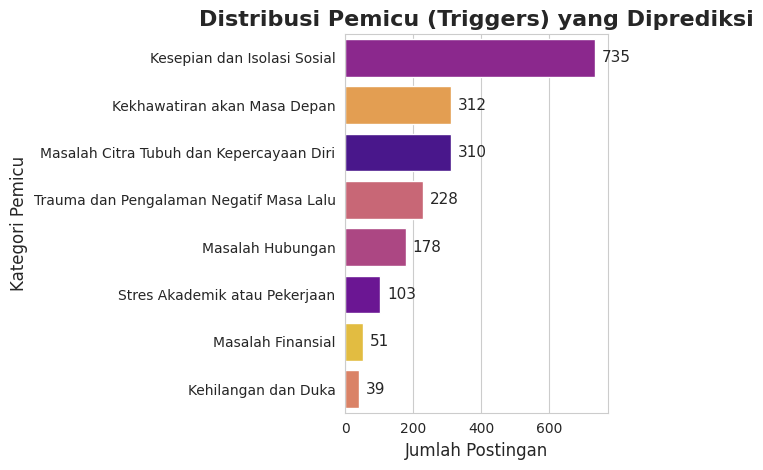

In [40]:
# Filter data untuk analisis (menghilangkan error jika ada)
plot_df = working_df[~working_df['predicted_trigger'].isin(['Error API', 'Lainnya/Tidak Terklasifikasi'])]

# Membuat bar chart untuk menghitung distribusi 'predicted_trigger'
ax = sns.countplot(y=plot_df['predicted_trigger'],
                   order=plot_df['predicted_trigger'].value_counts().index,
                   hue=plot_df['predicted_trigger'],
                   palette='plasma')

# Menambahkan judul dan label
plt.title('Distribusi Pemicu (Triggers) yang Diprediksi', fontsize=16, fontweight='bold')
plt.xlabel('Jumlah Postingan', fontsize=12)
plt.ylabel('Kategori Pemicu', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Menambahkan anotasi jumlah
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',
                (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(5, 0),
                textcoords='offset points', fontsize=11)

plt.tight_layout()
plt.show()

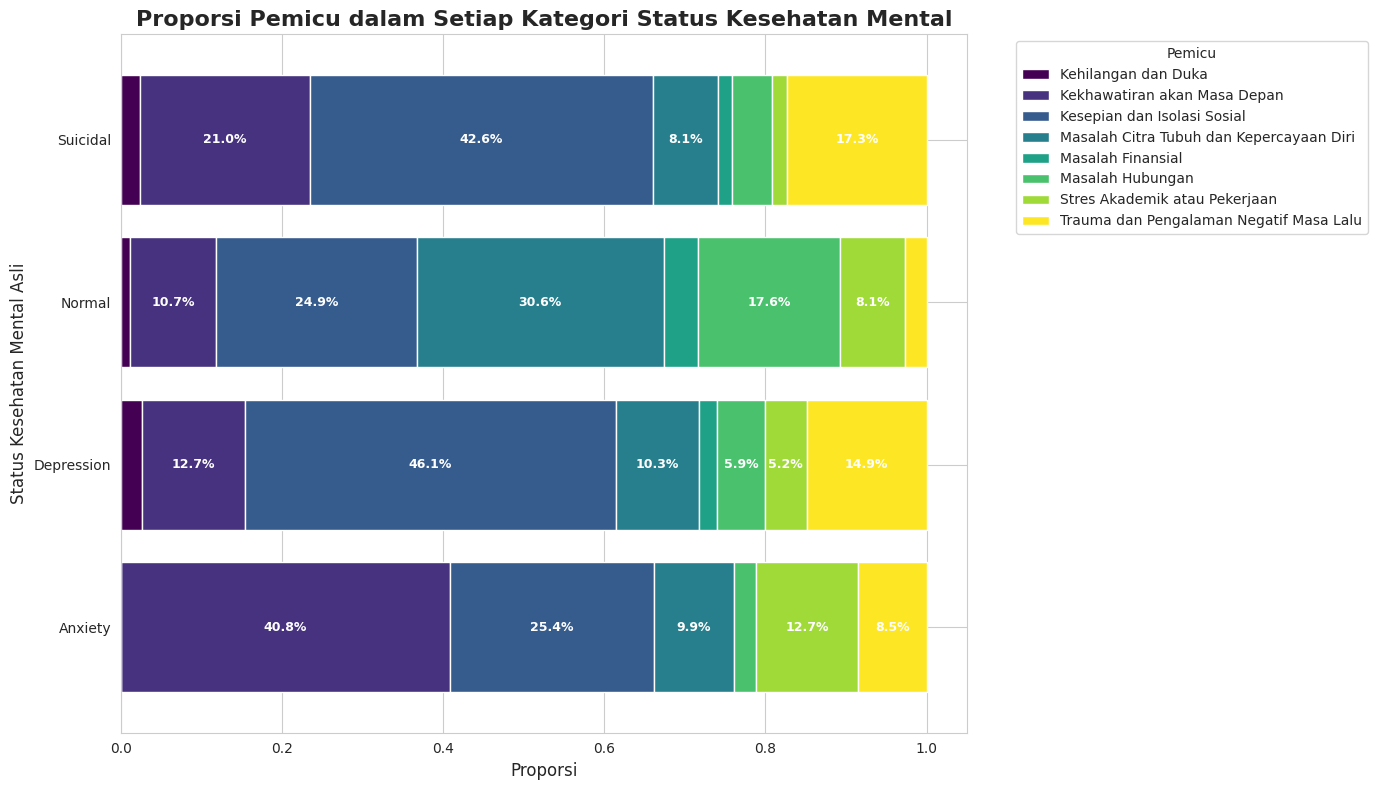

In [46]:
# Membuat tabel kontingensi (crosstab) antara status mental dan pemicu
cross_tab = pd.crosstab(index=plot_df['status'],
                        columns=plot_df['predicted_trigger'])

# Normalisasi data untuk mendapatkan persentase (proporsi) per baris
cross_tab_norm = cross_tab.div(cross_tab.sum(axis=1), axis=0)

# Membuat stacked bar chart
ax = cross_tab_norm.plot(kind='barh', stacked=True, figsize=(14, 8),
                         colormap='viridis', width=0.8)

# Kustomisasi plot
plt.title('Proporsi Pemicu dalam Setiap Kategori Status Kesehatan Mental', fontsize=16, fontweight='bold')
plt.xlabel('Proporsi', fontsize=12)
plt.ylabel('Status Kesehatan Mental Asli', fontsize=12)
plt.legend(title='Pemicu', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Menambahkan label persentase di dalam bar (opsional, bisa ramai jika banyak kategori)
for n, x in enumerate([*cross_tab_norm.index.values]):
    for (proportion, y_loc) in zip(cross_tab_norm.loc[x],
                                    cross_tab_norm.loc[x].cumsum()):
        if proportion > 0.05: # Hanya tampilkan label untuk segmen > 5%
            plt.text(y=n,
                     x=y_loc - proportion/2,
                     s=f'{proportion:.1%}',
                     color="white",
                     fontsize=9,
                     fontweight='bold',
                     ha='center',
                     va='center')

plt.tight_layout()
plt.show()

In [47]:
def summarize_texts_with_granite(text_list, category_name):
    """
    Merangkum sekumpulan teks dari kategori pemicu tertentu menggunakan IBM Granite.
    """
    # Gabungkan beberapa pernyataan menjadi satu paragraf besar
    # Ambil sampel acak jika daftar terlalu panjang untuk menghindari melebihi batas token
    sample_size = min(20, len(text_list)) # Ambil maks 20 sampel
    combined_texts = ". ".join(pd.Series(text_list).sample(sample_size))

    prompt = f"""
    Anda adalah seorang peneliti psikologi yang sedang menganalisis data kualitatif.
    Berikut adalah sekumpulan pernyataan dari orang-orang yang mengalami "{category_name}".
    Baca semua pernyataan ini dan berikan rangkuman dalam 3-4 poin utama.
    Rangkuman harus mencakup tema umum, emosi yang sering muncul, dan masalah spesifik yang disebutkan.

    Pernyataan-pernyataan: "{combined_texts}"

    Berikan jawaban Anda dalam format poin-poin.
    """

    try:
        output = replicate.run(
            "ibm-granite/granite-3.3-8b-instruct",
            input={
                "prompt": prompt,
                "prompt_template": "<s>[INST] {prompt} [/INST]",
                "temperature": 0.5, # Suhu lebih tinggi untuk summarization yang lebih baik
                "max_new_tokens": 512 # Beri ruang lebih untuk rangkuman
            }
        )
        return "".join(output)
    except Exception as e:
        return f"Gagal membuat rangkuman: {e}"

# Pilih kategori pemicu yang paling umum untuk dirangkum
most_common_trigger = plot_df['predicted_trigger'].mode()[0]
print(f"Membuat Rangkuman untuk Pemicu Paling Umum: '{most_common_trigger}'\n" + "="*50)

# Kumpulkan semua teks untuk kategori tersebut
texts_to_summarize = plot_df[plot_df['predicted_trigger'] == most_common_trigger]['cleaned_statement'].tolist()

# Hasilkan dan cetak rangkuman
summary = summarize_texts_with_granite(texts_to_summarize, most_common_trigger)
print(summary)

Membuat Rangkuman untuk Pemicu Paling Umum: 'Kesepian dan Isolasi Sosial'
1. **Intense Loneliness and Social Isolation**: Many individuals express profound feelings of loneliness, social isolation, and a lack of meaningful connections. They describe minimal or superficial interactions, often limited to work or brief exchanges with coworkers. There's a consistent theme of yearning for genuine friendships and a supportive social network.

2. **Chronic Depression and Lack of Direction**: A recurring theme is chronic depression, often accompanied by a sense of purposelessness and lack of direction in life. Individuals struggle with identifying their passions or career goals, leading to feelings of being lost and without a clear path forward. This is compounded by body dysmorphia and self-criticism, where they constantly compare themselves negatively to others.

3. **Transgender Identity and Related Stress**: Some individuals grapple with their transgender identity, describing the distress 